In [3]:
# importing important libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.preprocessing.image import load_img
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
from tqdm import tqdm
import os

# Base directory of the dataset
BASE_DIR = "Dataset/UTKFace"

# Lists to store extracted data
image_paths = []
age_labels = []
gender_labels = []

# Process each file in the dataset
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')  # Split filename into components
    age = int(temp[0])  # Extract age
    gender = int(temp[1])  # Extract gender
    image_paths.append(image_path)  # Add image path
    age_labels.append(age)  # Add age label
    gender_labels.append(gender)  # Add gender label

100%|██████████| 23708/23708 [00:00<00:00, 348642.99it/s]


In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)


,image,age,gender
0,Dataset/UTKFace\100_0_0_20170112213500903.jpg....,100,0
1,Dataset/UTKFace\100_0_0_20170112215240346.jpg....,100,0
2,Dataset/UTKFace\100_1_0_20170110183726390.jpg....,100,1
3,Dataset/UTKFace\100_1_0_20170112213001988.jpg....,100,1
4,Dataset/UTKFace\100_1_0_20170112213303693.jpg....,100,1


In [6]:
df.tail(5)

,image,age,gender
23703,Dataset/UTKFace\9_1_3_20161220222856346.jpg.ch...,9,1
23704,Dataset/UTKFace\9_1_3_20170104222949455.jpg.ch...,9,1
23705,Dataset/UTKFace\9_1_4_20170103200637399.jpg.ch...,9,1
23706,Dataset/UTKFace\9_1_4_20170103200814791.jpg.ch...,9,1
23707,Dataset/UTKFace\9_1_4_20170103213057382.jpg.ch...,9,1


In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [8]:
from PIL import Image #Python Imaging Library (Pillow) module for image processing tasks such as resizing and handling grayscale images.
from keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm #It provides a progress bar for iterating through a loop. This is useful for visual feedback when processing a large number of images.


def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)  # LANCZOS is a high-quality down-sampling filter
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # For grayscale images, reshape to (num_samples, 128, 128, 1)
    features = features.reshape(len(features), 128, 128, 1)  # 1 channel for grayscale
    return features

In [9]:
X = extract_features(df['image'])

100%|██████████| 23708/23708 [02:52<00:00, 137.73it/s]


In [10]:
X.shape

(23708, 128, 128, 1)

In [11]:
# normalize the images
X = X/255.0

In [12]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [13]:
input_shape = (128, 128, 1) #dimensions of data fed into network

In [14]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs) #32 filters of 3x3 size - ReLu activation function
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1) #Reduces spatial dimensions by taking the maximum value in each 2x2 region.
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4) #Converts the 2D feature maps (output from the final pooling layer) into a 1D vector.

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

# This CNN model extracts features from images and predicts both gender (classification) and age (regression).
# It uses shared convolutional layers for feature extraction and separate dense layers for each task.

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 111s 182ms/step - age_out_loss: 10.4670 - age_out_mae: 10.4693 - gender_out_accuracy: 0.5334 - gender_out_loss: 0.6901 - loss: 11.1595 - val_age_out_loss: 32.0399 - val_age_out_mae: 32.1720 - val_gender_out_accuracy: 0.6738 - val_gender_out_loss: 0.6297 - val_loss: 32.8035
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 110s 186ms/step - age_out_loss: 7.7411 - age_out_mae: 7.7407 - gender_out_accuracy: 0.7546 - gender_out_loss: 0.5022 - loss: 8.2430 - val_age_out_loss: 28.9471 - val_age_out_mae: 29.0649 - val_gender_out_accuracy: 0.7537 - val_gender_out_loss: 0.5140 - val_loss: 29.5796
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 116s 195ms/step - age_out_loss: 7.0421 - age_out_mae: 7.0426 - gender_out_accuracy: 0.8193 - gender_out_loss: 0.3973 - loss: 7.4399 - val_age_out_loss: 27.5571 - val_age_out_mae: 27.6701 - val_gender_out_accuracy: 0.7693 - val_gender_out_loss: 0.4858 - val_loss: 28.1559
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 132s 222ms/step - age_ou

In [ ]:
# Save the trained model to a file
# This saves the model's architecture, weights, and the state of the optimizer.
model.save('Models/age_gender_model.h5')

print("Model saved successfully to 'age_gender_model.h5'")

Model saved successfully to 'age_gender_model.h5'


In [ ]:
# Alternatively, save to the recommended .keras format
model.save('Models/age_gender_model.keras')
print("Model saved successfully to 'age_gender_model.keras'")

Model saved successfully to 'age_gender_model.keras'


In [19]:
# Print the final accuracy for gender and age predictions
gender_accuracy = history.history['gender_out_accuracy'][-1]
age_accuracy = history.history['age_out_mae'][-1]

print(f"Final Gender Prediction Accuracy: {gender_accuracy:.4f}")
print(f"Final Age Prediction MAE: {age_accuracy:.4f}")


Final Gender Prediction Accuracy: 0.9505
Final Age Prediction MAE: 3.1593


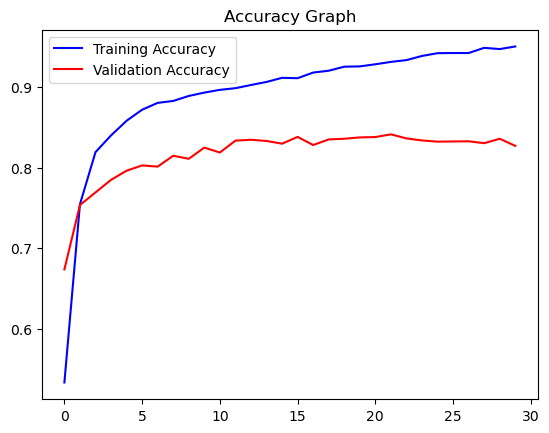

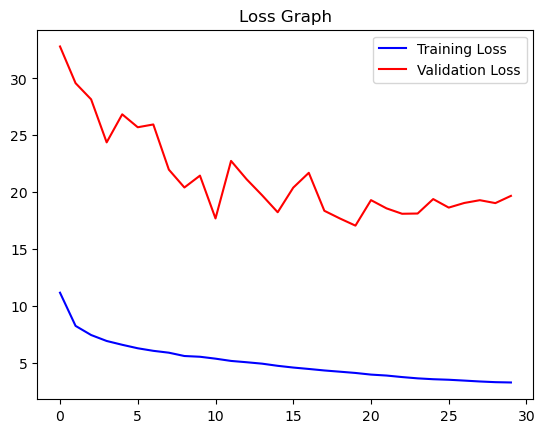

In [20]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

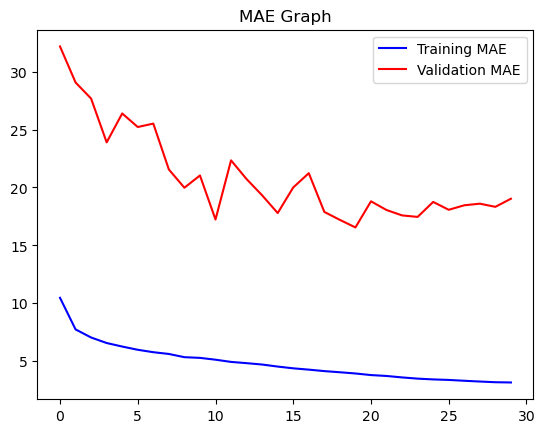

In [21]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('MAE Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Predicted Gender: Male Predicted Age: 12


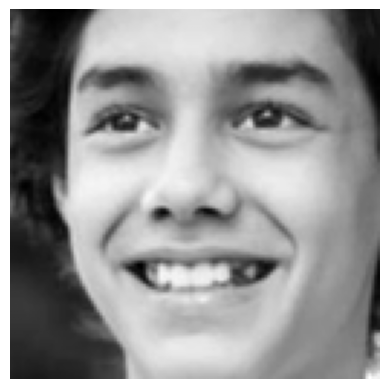

In [22]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')

Original Gender: Female Original Age: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted Gender: Female Predicted Age: 2


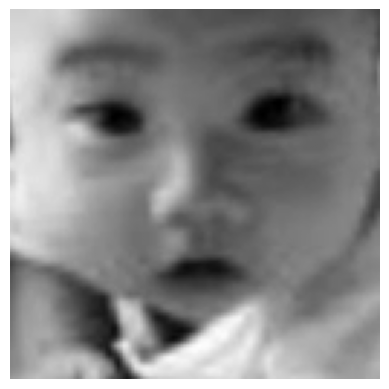

In [24]:
image_index = 2413
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')